# Cleaning Data

This notebook is dedicated to visualizing and cleaning up the data for 3D Sparse Tensor Network modeltraining.

In [1]:
#imports
import h5py
import numpy as np
import os.path
import click
import matplotlib.pyplot as plt

## Load Data

The h5 file should be copied from the directory provided in the *data* Slack channel.

In [2]:
LOADFROM = "../mg22simulated/"
H5 = "output_digi_HDF_Mg22_Ne20pp_8MeV.h5"

file = h5py.File(LOADFROM + H5, 'r')

Format the data into a numpy array. The conversion from h5 to numpy array takes a while.

In [3]:
file = h5py.File(LOADFROM + H5, 'r')

original_keys = list(file.keys())
original_length = len(original_keys)

event_lens = np.zeros(original_length, int)
for i in range(original_length):
    event = original_keys[i]
    event_lens[i] = len(file[event])
    
ISOTOPE = 'Mg22'
file_name = ISOTOPE + '_w_key_index'
# **only doing this if the file doens't exist already, as the conversion takes a while**
if not os.path.exists(LOADFROM + file_name + '.npy'):
    event_data = np.zeros((original_length, np.max(event_lens), 13), float) 
    for n in range(len(original_keys)):
        name = original_keys[n]
        event = file[name]
        ev_len = len(event)
        #converting event into an array
        for i,e in enumerate(event):
            instant = np.array(list(e))
            event_data[n][i][:12] = np.array(instant)
            event_data[n][i][-1] = float(n) #insert index value to find corresponding event ID
    np.save(LOADFROM + file_name, event_data)

Check the shape of the data. It should be (10000, 1476, 13).

In [4]:
data = np.load(LOADFROM + ISOTOPE + '_w_key_index' + '.npy')
print(f'Data Shape = {data.shape}') # Expected output: (10000, 1476, 13)

Data Shape = (10000, 1476, 13)


We only want to use the x, y, z, amplitude, and track ID columns, so we will slice out the useful data.

In [5]:
# slice useful elements
# [0] - x, [1] - y, [2] - z, [4] - amp, [5] - track_id 
sliced_data = data[:, :, [0, 1, 2, 4, 5]]

## Visualizing the Data

We need to understand what are the useful parts of the data, since there are junk events with empty beam. To do that, we want to understand the distribution of the data and visualize it with plots.

First, we look at the distribution of the number of detections for each event. This is a good indicator of empty events, as the number of detections will give us an idea of which events are simply single beam junk events.

From the plot below, we see that a large number of events have less than around 60-70 detections, so it would be reasonable to assume those as junk beam events with no nuclear reaction.

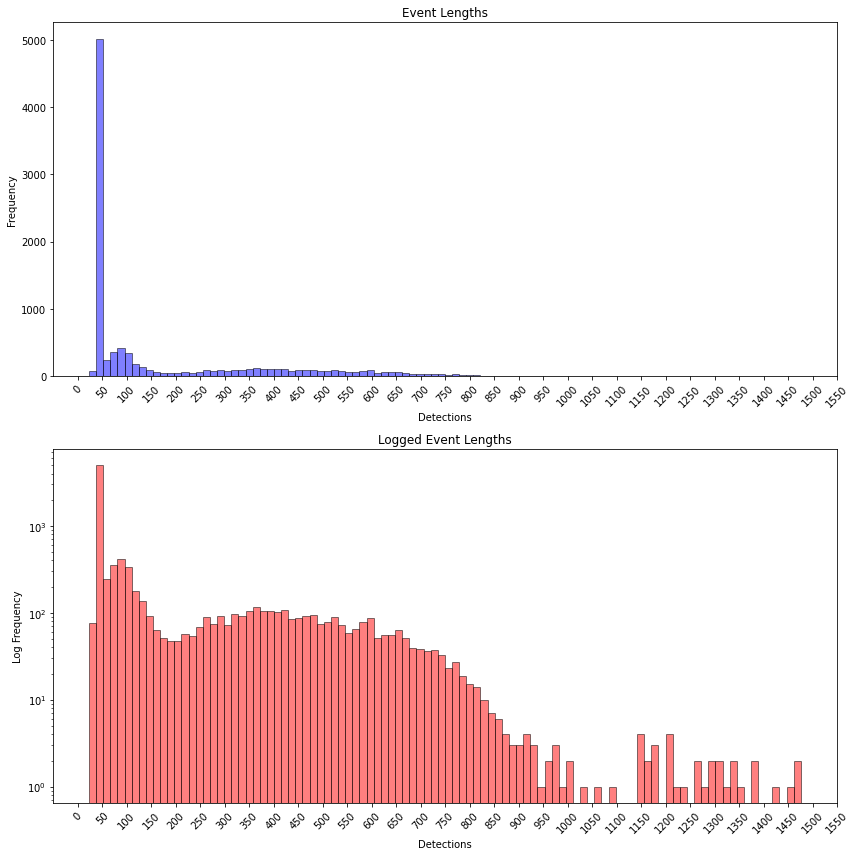

In [6]:
# Set the figure size
plt.figure(figsize=(12, 12))  # Adjusted height to accommodate both subplots

# First subplot for the unlogged histogram
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st plot
plt.hist(event_lens, bins=100, edgecolor='black', alpha=0.5, color='blue')
plt.title("Event Lengths")
plt.xlabel("Detections")
plt.ylabel("Frequency")
xticks = np.arange(0, 1600, 50)
plt.xticks(xticks, rotation=45)

# Second subplot for the logged histogram
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd plot
plt.hist(event_lens, bins=100, edgecolor='black', alpha=0.5, color='red', log=True)
plt.title("Logged Event Lengths")
plt.xlabel("Detections")
plt.ylabel("Log Frequency")
xticks = np.arange(0, 1600, 50)
plt.xticks(xticks, rotation=45)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

Next we also want to know around how many tracks there are in an event. We can drop all tracks with track ID 0, since those are just empty detections. We see that there is a maximum of 6 tracks for an event, indicating 6 different types of particles? (What does each track ID even represent?)

We see that track ID 4 has the highest frequency, indicating it is detected the most, while track ID 5, 6 are present, but are rarely detected.

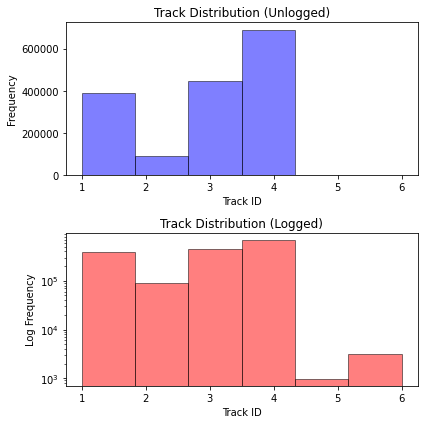

In [7]:
# Flatten the tracks array and remove zeros
tracks = sliced_data[:, :, -1]
tracksflat = tracks.flatten()
no_zeros = tracksflat[tracksflat != 0]

# Set the figure size
plt.figure(figsize=(6, 6))  # Adjusted height to accommodate both subplots

# First subplot for the unlogged histogram
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st plot
plt.hist(no_zeros, bins=6, edgecolor='black', color='blue', alpha=0.5)
plt.title("Track Distribution (Unlogged)")
plt.xlabel("Track ID")
plt.ylabel("Frequency")

# Second subplot for the logged histogram
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd plot
plt.hist(no_zeros, bins=6, edgecolor='black', color='red', alpha=0.5, log=True)
plt.title("Track Distribution (Logged)")
plt.xlabel("Track ID")
plt.ylabel("Log Frequency")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## Cleaning Data

As seen from the histograms above, there is a large number of events with a low number of detections. Those events are likely empty beam events, and so based on the binning of the histogram, events with under 70 detections will not be used for training. We will filter out these events. After the filtering for only events with more than 70 events, we see that there should now be 4591 events left.

In [8]:
LENEVTS = len(sliced_data) # number of events (10000)
LENDETS = len(sliced_data[0]) # number of detections (1476)
NUMCLASSES = 5 # x, y, z, amp, track_id
cutoff = 70 # discard events with less than 70 detections
newLen = np.sum(event_lens > 70)

new_data = np.zeros((newLen, LENDETS, NUMCLASSES), float)
new_data_index = 0

for i in range(LENEVTS):
    if event_lens[i] > 70:
        new_data[new_data_index] = sliced_data[i] 
        new_data_index += 1

print(f'New Number of Events = {len(new_data)}')

New Number of Events = 4591


Based on Ben Wagner's data proccessing pipeline, it was infered that events with less than four tracks were not reliable sources for training, so we will filter out events with less than four tracks. We further filter out from events with 70+ detections.

In [19]:
cleaned_data = np.zeros((2340, 1476, 5)) # the number of new events is determined to be 2340 after the filtering of events with 4+ tracks
cleaned_data_index = 0

for i in range(LENEVENTSNEW):
    track = new_data[i, :, -1]
    label, distr = np.unique(track, return_counts=True)
    # the length of the label here is 5, because for events with 4 tracks, label = [0, 1, 2, 3, 4]. The '0' does not count as a track ID
    if len(label) >= 5: 
        cleaned_data[cleaned_data_index] = new_data[i]
        cleaned_data_index += 1
print(f'Cleaned Data Events = {cleaned_data_index}')  # Expected output: 2340

Cleaned Data Events = 2340


The following plots are to visualize what each event looks like. Each plot is event specific. Change  variable *event* to plot different events in the cell below.

In [10]:
event = 2 # <--------- select event to plot
selected = cleaned_data[event]
unique_values = np.unique(selected[:, -1])

split_arrays = {}
for value in unique_values:
    split_arrays[value] = selected[selected[:, -1] == value]

We visualize what each track ID looks like in the following 3D plots. Each plot is for a specific track ID, with all the track IDs overlayed with each other in the final plot.

We plot each of the tracks exept for the track ID of 0, as those are just empty events. Each event has 1476 detections total, but most of them are those empty events. We see this as the island of dots with an amplitude of 0 in our final plot.

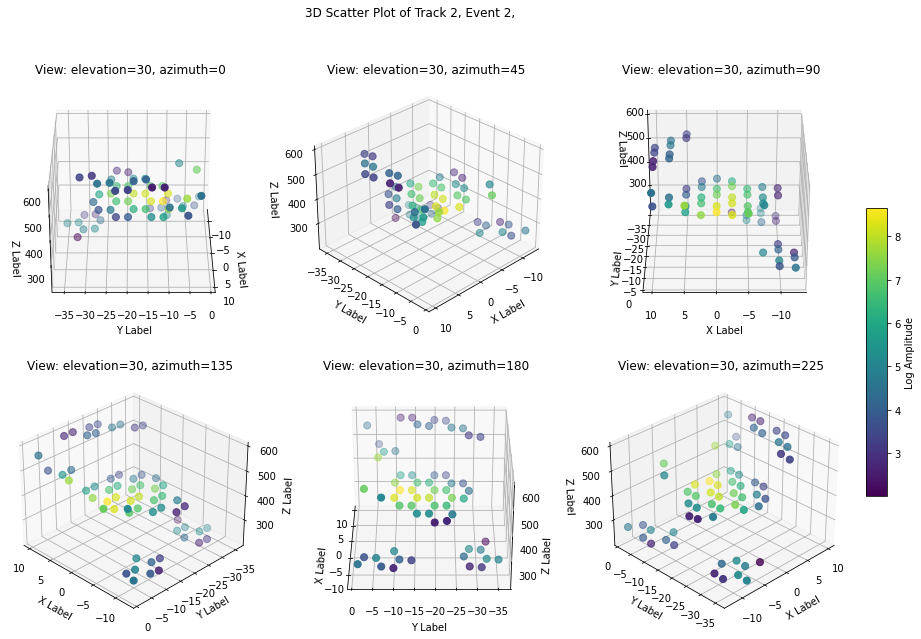

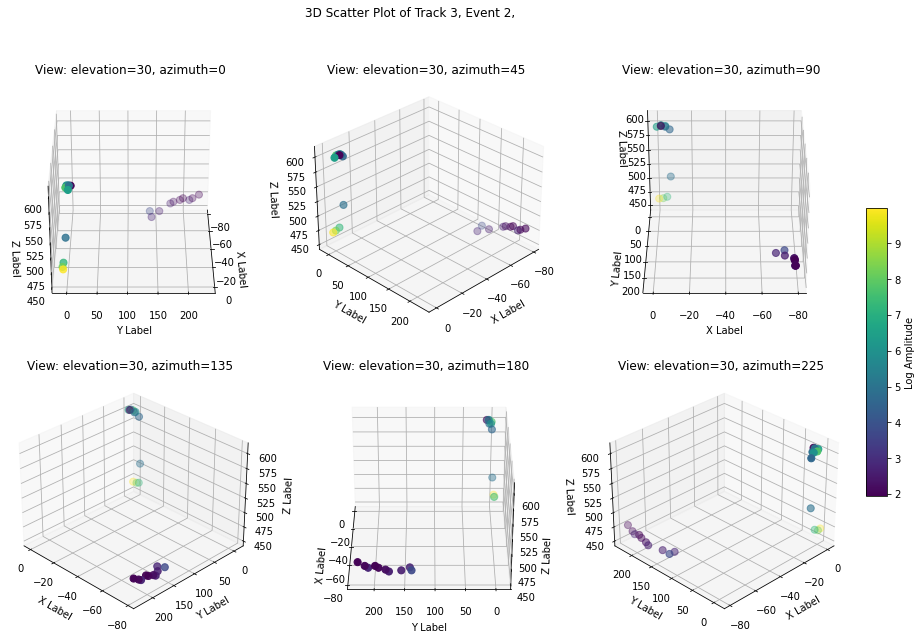

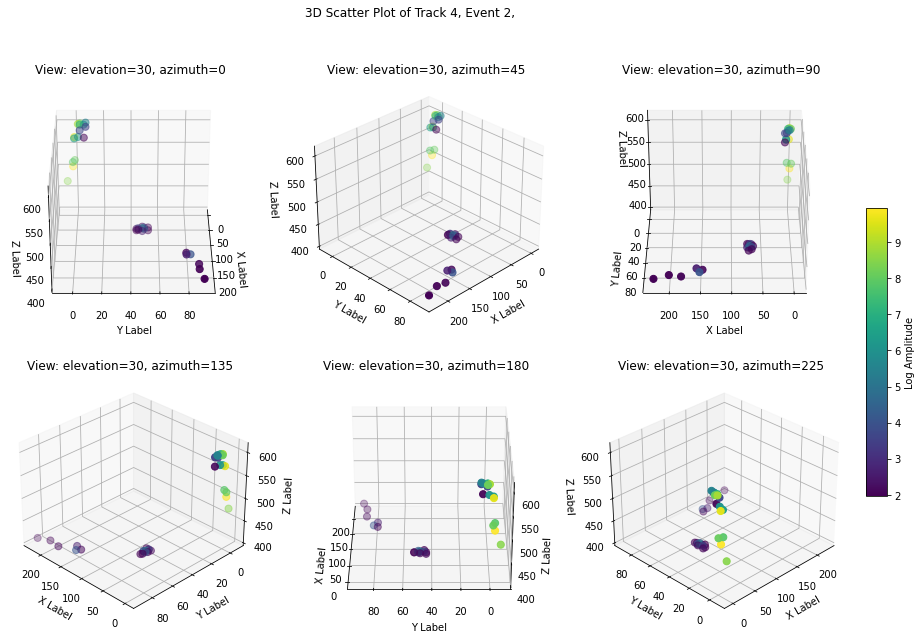

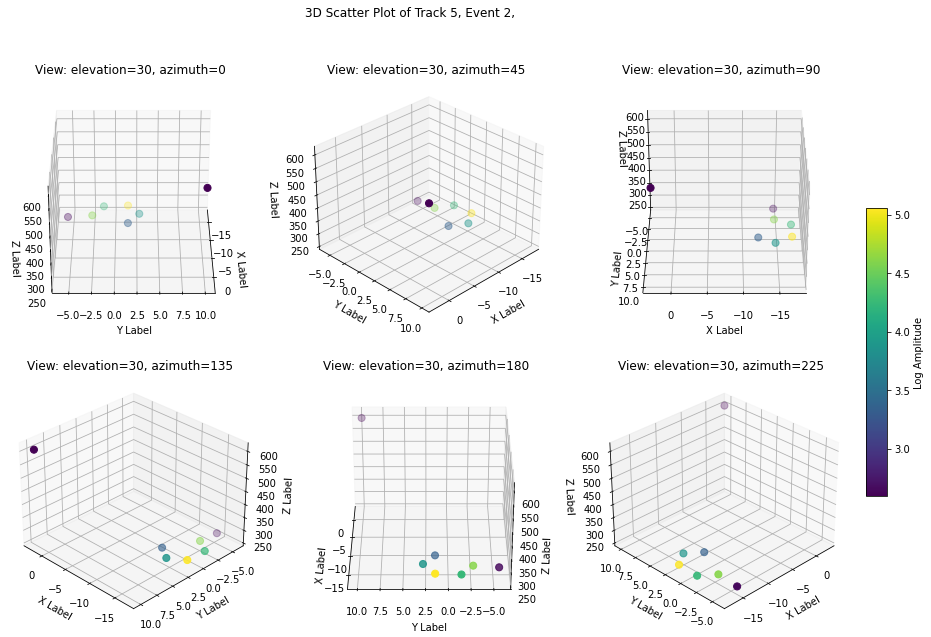

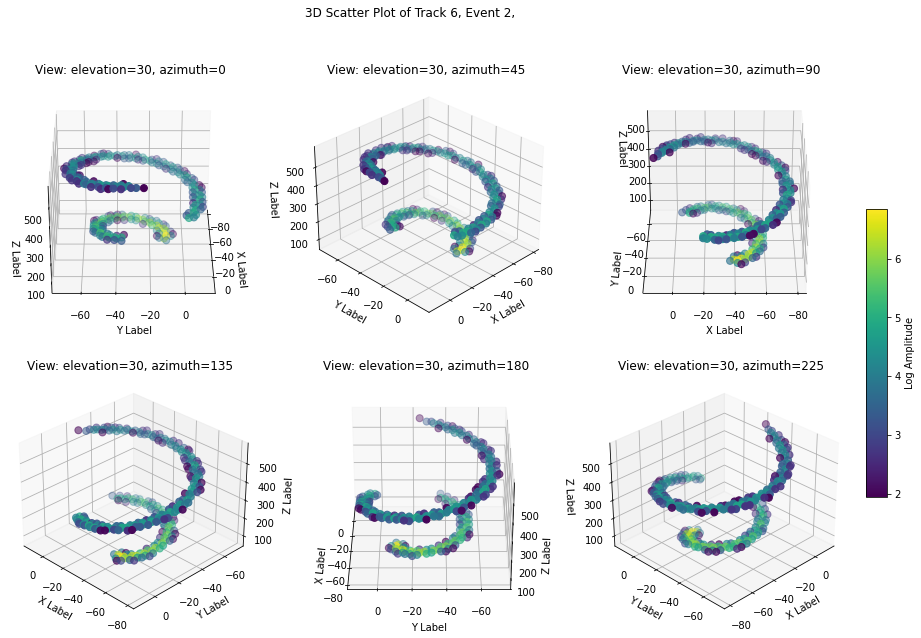

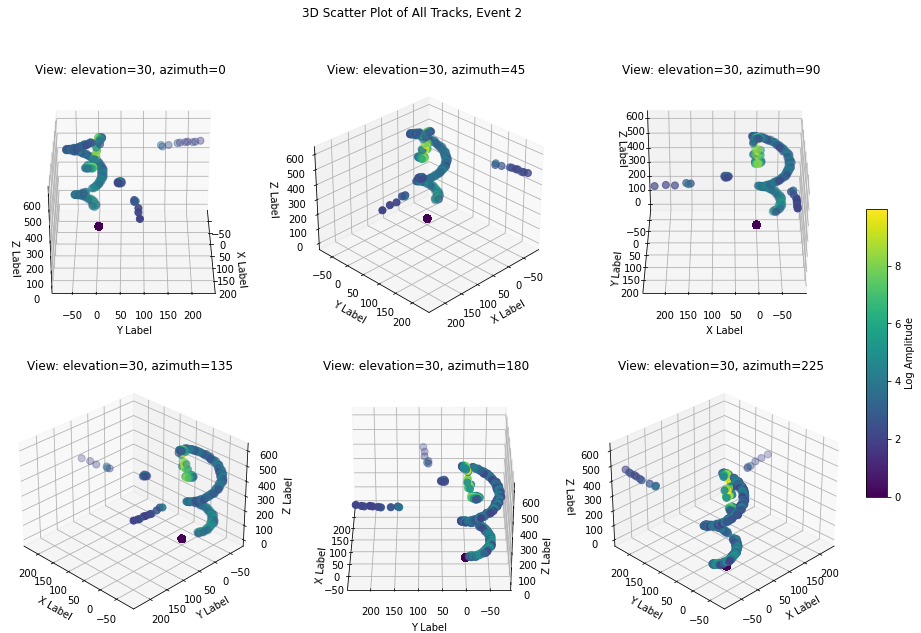

In [13]:
# Plotting Each Track
for index, (key, value) in enumerate(split_arrays.items()): 
    if key != 0.0:
        dict_data = split_arrays[key]
        
        x = dict_data[:, 0]
        y = dict_data[:, 1]
        z = dict_data[:, 2]
        amplitude = dict_data[:, 3]
        log_amplitude = np.log(amplitude + 1)
        
        # Subplot setup
        fig = plt.figure(figsize=(15, 10))
        angles = [(30, 0), (30, 45), (30, 90), (30, 135), (30, 180), (30, 225)]
        
        for i, (elev, azim) in enumerate(angles, start=1):
            ax = fig.add_subplot(2, 3, i, projection='3d')
            sc = ax.scatter(x, y, z, c=log_amplitude, cmap='viridis', s=50)

            # Set viewpoint
            ax.view_init(elev, azim)
            
            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')
            ax.set_title(f"View: elevation={elev}, azimuth={azim}")
        
        # Colorbar; since we have multiple subplots, we adjust the position for better layout
        cax = fig.add_axes([0.92, 0.3, 0.02, 0.4]) 
        cbar = fig.colorbar(sc, cax=cax)
        cbar.set_label('Log Amplitude')
        
        fig.suptitle(f"3D Scatter Plot of Track {int(key)}, Event {event}, ")
        plt.show()

# Plot all tracks overlayed with each other  
x = selected[:, 0]
y = selected[:, 1]
z = selected[:, 2]
amplitude = selected[:, 3]
log_amplitude = np.log(amplitude + 1)

# Subplot setup
fig = plt.figure(figsize=(15, 10))
angles = [(30, 0), (30, 45), (30, 90), (30, 135), (30, 180), (30, 225)]

for i, (elev, azim) in enumerate(angles, start=1):
    ax = fig.add_subplot(2, 3, i, projection='3d')
    sc = ax.scatter(x, y, z, c=log_amplitude, cmap='viridis', s=50)

    
    # Set viewpoint
    ax.view_init(elev, azim)
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title(f"View: elevation={elev}, azimuth={azim}")

# Colorbar; since we have multiple subplots, we adjust the position for better layout
cax = fig.add_axes([0.92, 0.3, 0.02, 0.4]) 
cbar = fig.colorbar(sc, cax=cax)
cbar.set_label('Log Amplitude')

fig.suptitle(f"3D Scatter Plot of All Tracks, Event {event}")
plt.show()

## Saving Arrays

The data has been sufficiently cleaned of junk events. Because numpy requires the arrays to be saved with the same dimensions, we cannot remove the empty detections when we save the data, and instead that has to be done as the data is being loaded for training.

First, we have to voxelize the x,y,z coordinates so they are integers. We do so by finding the min, max value and performing a linearfit.

In [ ]:
# For each specified column, get the min and max values
mins = cleaned_data[:, :, :4].min(axis=(0, 1))
maxs = cleaned_data[:, :, :4].max(axis=(0, 1))

print("Min values for x, y, z, amp:", mins)
print("Max values for x, y, z, amp", maxs)

Perform a linear fit of x, y, z to voxelize the coordinates so that it can be interpreted as a 3D image:

In [ ]:
def linearfit(x, min_orig, max_orig, min_desired, max_desired):
    return ((x - min_orig) / (max_orig - min_orig)) * (max_desired - min_desired) + min_desired